# ERP Enhancer

This notebook contains P300 enhancer based on ICA and apriori information about P300 latency (only ICA components with big amplitudes in [300 - $\epsilon$, 300 + $\epsilon$] are selected)

In [1]:
import matplotlib.pyplot as plt
from pylab import rcParams

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import mne

In [4]:
import pandas as pd

In [5]:
from scipy.io import loadmat

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
from sklearn.decomposition import IncrementalPCA

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [11]:
from sklearn.svm import SVC

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
import plotly.express as px

In [15]:
from sklearn.decomposition import PCA

In [16]:
from scipy.signal import argrelextrema

In [17]:
from scipy.io import loadmat, savemat

In [18]:
from tqdm import tqdm_notebook

In [19]:
MAIN_CHANNELS = ["Fz", "Cz", "P3", "Pz", "P4", "Po7", "Po8", "Oz"]

In [20]:
sfreq = 250

# Preprocess

## TODO Needs refactoring!

These steps were reimplemented in src/load.py and src/preprocess.py. Please look there to get additional comments.

In [21]:
def load_data(subject):
    channels = MAIN_CHANNELS
    
    session = loadmat('/tmp/{}.mat'.format(subject))

    session_df = pd.DataFrame(session["y"], columns=channels)

    sfreq = session["fs"][0][0]

    session_df["Time"] = session_df.index / session["fs"][0][0]

    session_df["Trigger"] = session["trig"]
    session_df.loc[session_df["Trigger"] == -1, "Trigger"] = 2
    
    return session_df

In [22]:
def restore_raw(session_df):
    channels = MAIN_CHANNELS + ['Trigger']
    info = mne.create_info(ch_names=channels, sfreq=sfreq)

    raw = mne.io.RawArray(session_df[channels].values.T, info)

    channel_types = {c: 'eeg' for c in channels}
    channel_types['Trigger'] = 'stim'

    raw.set_channel_types(channel_types)
    
    return raw

In [23]:
def filter_signal(raw):
    raw.notch_filter(50)
    raw.filter(0.5, 30)

In [24]:
def plot_raw(raw, start=30, stop=50, scale=100):
    rcParams['figure.figsize'] = 15, 10
    mne.viz.plot_raw(
        raw, 
        start=start, 
        duration=stop - start, 
        show=False, 
        n_channels=9,
        scalings={'eeg': scale}
    )
    plt.show()

In [25]:
def scale_signal(raw, session_df):
    channels = MAIN_CHANNELS + ['Trigger']
    
    events = mne.find_events(raw, 'Trigger')
    channels_data = raw.copy().pick_types(eeg=True).get_data()
    training_data = channels_data[:, (events[0][0] // 2):events[0][0] - 1]

    trigger_data = session_df["Trigger"].values

    scaler = StandardScaler()
    scaler.fit(training_data.T)
    scaled_channels_data = scaler.transform(channels_data.T).T
    
#     import pdb
#     pdb.set_trace()

    np.mean(scaled_channels_data, axis=1)

    new_channels_data = np.vstack([
        scaled_channels_data,
        trigger_data[np.newaxis, :]
    ])

    raw = mne.io.RawArray(new_channels_data, raw.info)
    
    channel_types = {c: 'eeg' for c in channels}
    channel_types['Trigger'] = 'stim'

    raw.set_channel_types(channel_types)
    
    return raw

In [26]:
def remove_artifacts(raw, n_components=2):
    print("Removing artifacts with {}".format(n_components))
    ica = mne.preprocessing.ICA()

    ica.fit(raw)

    ica_eeg = ica.get_sources(raw)

    plt.figure(figsize=(10, 5))
    plt.plot(ica_eeg[:, :][0].T + 10 * np.arange(0, 8))

    stds = np.std(np.abs(ica_eeg[:, :][0]), axis=1)
    exclude_components = (-stds).argsort()[0:n_components + 1]

    raw = ica.apply(raw.copy(), exclude=list(exclude_components))
    
    return raw

In [27]:
def get_epochs(raw):
    events = mne.find_events(raw, 'Trigger')
    
    epochs = mne.Epochs(
        raw.pick_types(eeg=True), 
        events, tmin=-0.1, tmax=0.7,
#         reject_by_annotation=False,
        preload=True
    )
#     epochs = epochs.apply_baseline((-0.1, 0))
    return epochs

In [28]:
def show_p300_plots(epochs):
    epochs['1'].average().plot()
    plt.show()
    
    epochs['2'].average().plot()
    plt.show()

In [29]:
def process_signal(i, n_components=2):
    subject = "S{}".format(i)
    session_df = load_data(subject)
    raw = restore_raw(session_df)
    plot_raw(raw)
    
    filter_signal(raw)
    plot_raw(raw)
    
    raw = scale_signal(raw, session_df)
    plot_raw(raw, scale=10)
    
#     raw = remove_artifacts(raw, n_components)
    
    epochs = get_epochs(raw)    
#     show_p300_plots(epochs)
    
    return epochs

Creating RawArray with float64 data, n_channels=9, n_times=25327
    Range : 0 ... 25326 =      0.000 ...   101.304 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-22-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



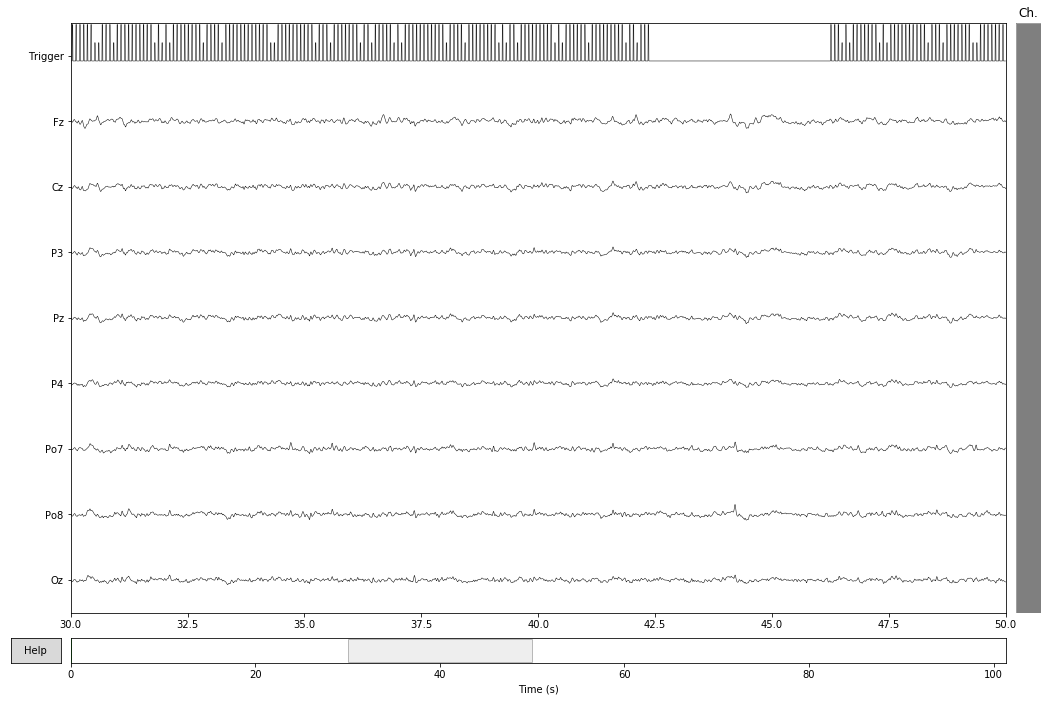

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


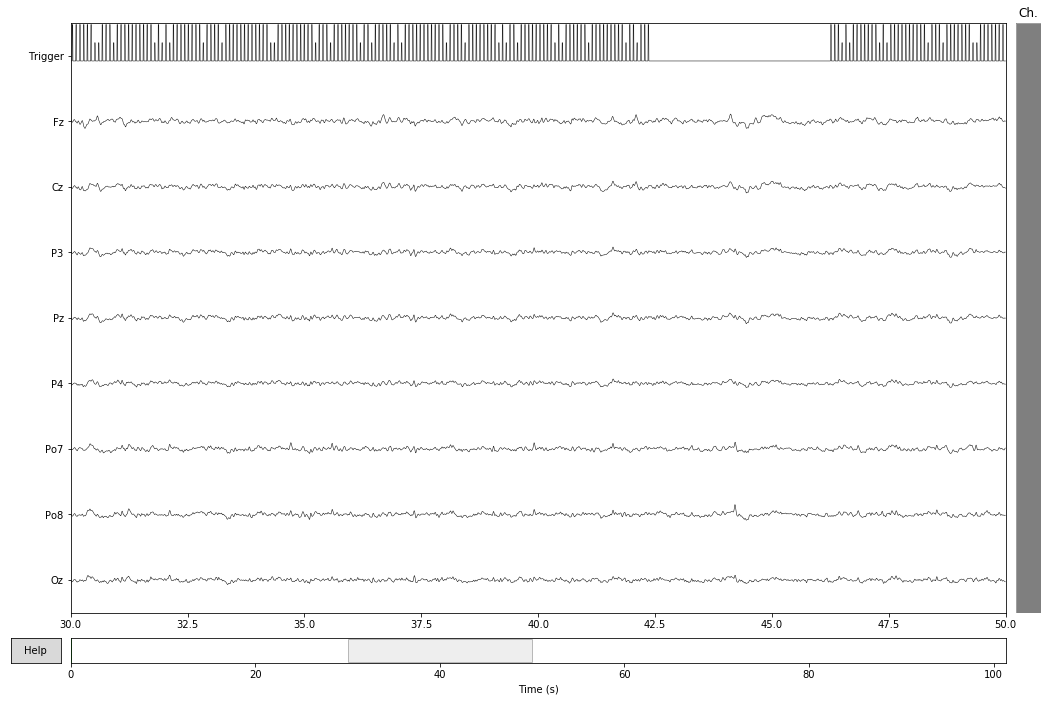

900 events found
Event IDs: [1 2]
Creating RawArray with float64 data, n_channels=9, n_times=25327
    Range : 0 ... 25326 =      0.000 ...   101.304 secs
Ready.


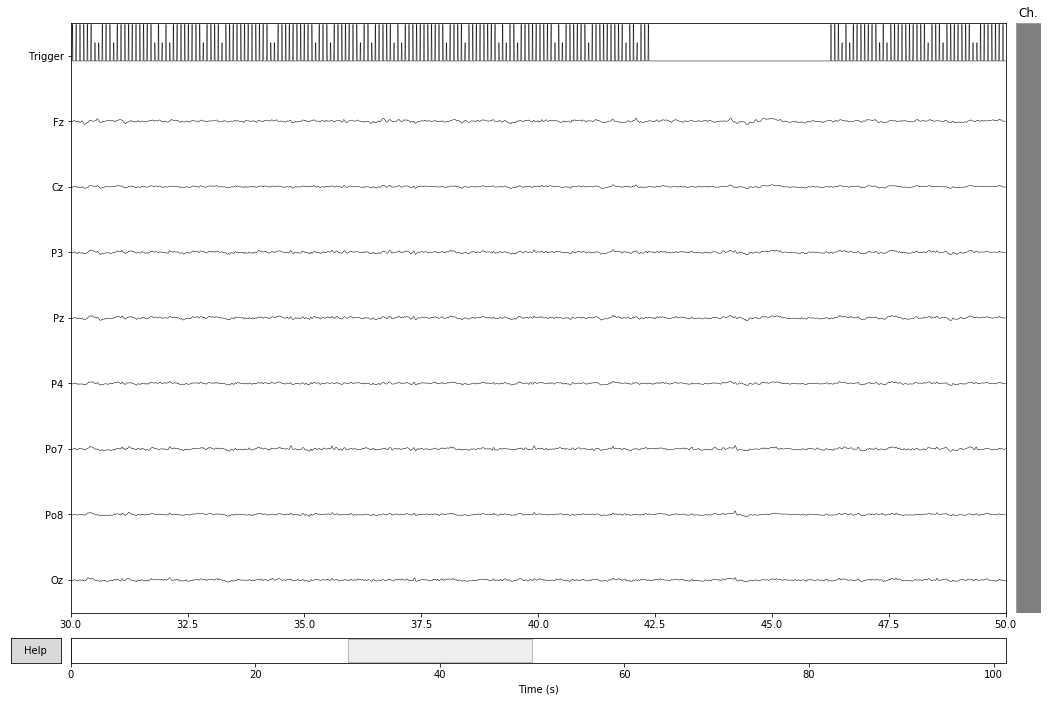

900 events found
Event IDs: [1 2]
900 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 900 events and 201 original time points ...
0 bad epochs dropped


In [178]:
epochs = process_signal(6)

# ICA Enhancer

## TODO Needs refactoring

Fit ICA using all epochs for one subject

In [179]:
ica = mne.preprocessing.ICA()
ica.fit(epochs)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 1.3s.


<ICA  |  epochs decomposition, fit (fastica): 180900 samples, 8 components, channels used: "eeg">

Get ICA sources only for positive attemps

In [180]:
ica_eeg = ica.get_sources(epochs['1'])

In [181]:
test_data = ica_eeg.get_data()
test_time = np.linspace(-100, 700, 201)

Get amplitudes in a range of [200, 450]. Select components:
- With a significant statistical difference between baseline values and p300 range values
    - Two-tailed test
    - One-tailed test, abs
- With avg value bigger than the threshold (as recommended in paper)

Visualize accepted and rejected components

In [182]:
def convert_time_to_sample(x):
    return np.argmin(np.abs(test_time - x))

In [183]:
baseline_start = convert_time_to_sample(-100)
baseline_end = convert_time_to_sample(0)

In [184]:
baseline_start, baseline_end

(0, 25)

In [185]:
p300_start_time = 200
p300_end_time = 450

In [186]:
p300_start = convert_time_to_sample(p300_start_time)
p300_end = convert_time_to_sample(p300_end_time)

In [187]:
p300_start, p300_end

(75, 137)

In [188]:
baseline_test_data = test_data[:, :, baseline_start:baseline_end]
p300_test_data = test_data[:, :, p300_start:p300_end]

In [189]:
import seaborn as sns

In [190]:
from scipy.stats import mannwhitneyu, ttest_ind

0 0.9990670284051617
1 0.9999277237309299
2 0.988367811174666
3 0.9999999989878607
4 0.9999999999717908
5 0.9921159021936042
6 3.63468614524604e-11
7 0.7150709284986426


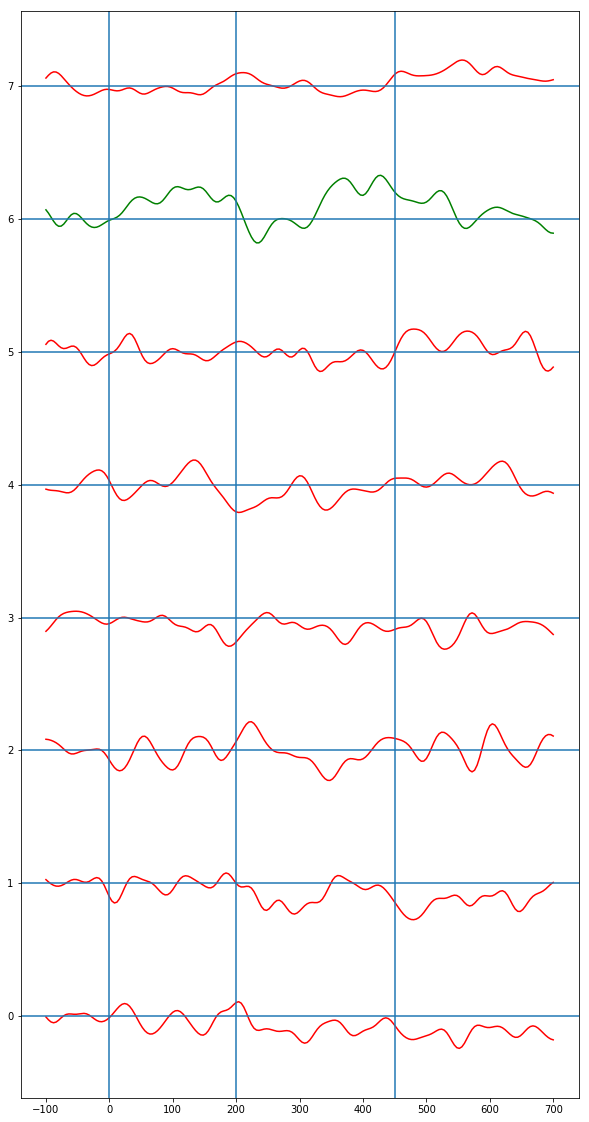

In [191]:
components = []
plt.figure(figsize=(10, 20))
for c in range(0, 8):
    pvalue = mannwhitneyu(
        baseline_test_data[:, c, :].reshape(-1), 
        p300_test_data[:, c, :].reshape(-1),
        alternative='less'
    ).pvalue
    
    color = 'green'
    
    if pvalue > 0.01:
        components.append(c)
        color = 'red'
    
    print(c, pvalue)
    plt.plot(test_time, test_data[:, c, :].mean(axis=0) + c, color=color)
    plt.axhline(c)

plt.axvline(p300_start_time)
plt.axvline(p300_end_time)
plt.axvline(0)
plt.show()

Apply ERP Filter

In [192]:
best_components = components

In [193]:
new_epochs = ica.apply(epochs['1'].copy(), exclude=best_components)

Transforming to ICA space (8 components)
Zeroing out 7 ICA components


time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-194-25cd1e677c49>:1: DeprecationWarning:

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning



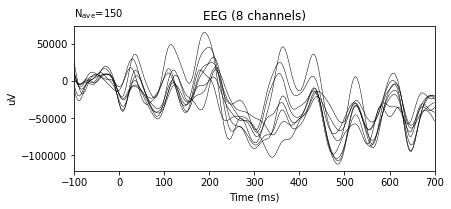

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-194-25cd1e677c49>:3: DeprecationWarning:

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning



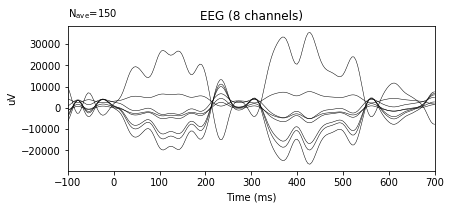

In [194]:
epochs['1'].average().plot()
plt.show()
new_epochs.average().plot()
plt.show()

Мы ищем комбинацию из N компонент, которая максимизирует минимальную амплитуду для окна

In [69]:
# components = []
# plt.figure(figsize=(10, 20))
# for c in range(0, 8):
#     mean_amplitude = np.mean(np.abs(p300_test_data[:, c, :]))
    
#     color = 'green'
        
#     if mean_amplitude < 0.8:
#         components.append(c)
#         color = 'red'
    
#     print(c, mean_amplitude)
#     plt.plot(test_time, test_data[:, c, :].mean(axis=0) + (8 - c), color=color)
#     plt.axhline((8 - c))

# plt.axvline(200)
# plt.axvline(450)
# plt.axvline(0)
# plt.show()

Hyperparameter search for P300 amplitude maximization

In [63]:
import itertools

In [45]:
def iterate_component_tuples(n_components):
    yield []
    for order in range(1, n_components):
        for combination in itertools.combinations(range(0, n_components), order):
            yield list(combination)

In [46]:
from tqdm import tqdm_notebook

In [52]:
best_components = []
max_amplitude = -1000000

for components in tqdm_notebook(list(iterate_component_tuples(8))):
    print(components)
    new_epochs = ica.apply(epochs['1'].copy(), exclude=components)
    baseline_value = epochs['1'].get_data()[:, :, baseline_start:baseline_end].mean(axis=-1).mean(axis=0).mean()
    p300_value = new_epochs.get_data()[:, :, p300_start:p300_end].mean(axis=-1).mean(axis=0).mean()
    amplitude = p300_value - baseline_value
    
    if (amplitude > max_amplitude) & ~np.isnan(amplitude):
        max_amplitude = amplitude
        best_components = components

[]
Transforming to ICA space (8 components)
Zeroing out 0 ICA components
[0]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[1]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[2]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[3]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[4]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[5]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[6]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[7]
Transforming to ICA space (8 components)
Zeroing out 1 ICA components
[0, 1]
Transforming to ICA space (8 components)
Zeroing out 2 ICA components
[0, 2]
Transforming to ICA space (8 components)
Zeroing out 2 ICA components
[0, 3]
Transforming to ICA space (8 components)
Zeroing out 2 ICA components
[0, 4]
Transforming to ICA space (8 components)
Zeroing out 2 ICA components
[0, 5]
Transforming to ICA 

[0, 1, 4, 7]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 1, 5, 6]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 1, 5, 7]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 1, 6, 7]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 3, 4]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 3, 5]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 3, 6]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 3, 7]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 4, 5]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 4, 6]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 4, 7]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 2, 5, 6]
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
[0, 

Zeroing out 5 ICA components
[1, 2, 3, 5, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 2, 3, 6, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 2, 4, 5, 6]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 2, 4, 5, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 2, 4, 6, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 2, 5, 6, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 3, 4, 5, 6]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 3, 4, 5, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 3, 4, 6, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 3, 5, 6, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[1, 4, 5, 6, 7]
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
[2, 3, 4, 5, 6]
Transform

In [53]:
max_amplitude

0.0008835978175572051

Почему одни субъекты классифицируются хорошо, другие - плохо?
- Использовать TS валидацию вместо случайной
- Извлечь признаки для скользящих окон
- Посмотреть, какие из окон классифицируются плохо, какие - хорошо
- Разделить их в пространстве признаков ERP

Изменения:
- Во времени - ослабление внимания, 
- Между субъектами - нарушение контакта электродов, непонимание эксперимента, 
- Конкретные попытки - артефакты движений, 

Гипотезы:
- Пространство признаков - задержка, амплитуда, номер попытки, низкие частоты, дисперсия, качество классификации LDA leave-one-out (оставить только N положительных попыток и соответствующее количество ближайших отрицательных попыток)
- При ослаблении внимания со временем уменьшается амплитуда и увеличивается задержка для более поздних попыток того же субъекта.  
- Если у субъекта было нарушение контакта электродов, то для всего субъекта будет низкое качество классификации, высокая дисперсия
- Если конкретные попытки плохо классифицируются, то для них будет отличаться низкочастотная составляющая.